# Action 2 : 기여도 분석 및 시뮬레이션을 통한 예산 최적화
- 도메인 및 모델 기반 Attribution Model을 이용한 캠페인 기여도 분석

---

---

---

# 데이터 살펴보기
- 데이터셋 출처: https://ailab.criteo.com/ressources/ (광고 리타겟팅 회사 Criteo)

<br/>

- **Timestamp**: timestamp of the impression
    - 캠페인이 노출된 시간
- **UID**: unique user identifier : user id
- **Campaign**: unique campaign identifier
    - 유니크한 캠페인의 ID
- **Conversion**: 1 if there was a conversion in the 30 days after the impression; 0 otherwise
    - 노출 후에 30일 이내에 전환이 일어나면 1
- **Conversion ID**: a unique identifier for each conversion
    - 전환이 일어났을 때, 전환에 대한 유니크한 ID
- **Click**: 1 if the impression was clicked; 0 otherwise
    - 유저가 노출된 것을 보고 클릭하면 1, 무시하면 0
- **Cost**: the price paid for this ad
- **Cat1-Cat9**: categorical features associated with the ad. These features’ semantic meaning is not disclosed.
    - 캠페인이 어떤 카테고리에 속하는지에 대한 카테고리 정보

In [1]:
df = pd.read_csv('data/criteo_attribution_dataset_sampled_campaign_300_journey_over_2_points_balanced.csv')
df = df.iloc[:, 2:]

print(df.shape)
df.head(2)

(602160, 23)


,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid
0,209415,21670661,10474106,1,1420115,17559949,0,1,4,8,...,30763035,9312274,30867372,29196072,11409684,30763035,8549927,29196072,29520626,21670661_17559949
1,225512,32320979,28874676,0,-1,-1,0,1,-1,-1,...,30763035,9312274,1461750,29196072,26611394,1973606,30600973,9068204,15351053,32320979_-1


In [2]:
for col in df.columns:
    print(f"{col} Unique Classes : {df[col].nunique()}")

timestamp Unique Classes : 501483
uid Unique Classes : 107463
campaign Unique Classes : 300
conversion Unique Classes : 2
conversion_timestamp Unique Classes : 78799
conversion_id Unique Classes : 79768
attribution Unique Classes : 2
click Unique Classes : 2
click_pos Unique Classes : 143
click_nb Unique Classes : 89
cost Unique Classes : 524248
cpo Unique Classes : 104681
time_since_last_click Unique Classes : 313370
cat1 Unique Classes : 9
cat2 Unique Classes : 44
cat3 Unique Classes : 818
cat4 Unique Classes : 19
cat5 Unique Classes : 41
cat6 Unique Classes : 30
cat7 Unique Classes : 7431
cat8 Unique Classes : 11
cat9 Unique Classes : 30
jid Unique Classes : 124258


---

### 자주 등장하는 상위 50개의 캠페인 추출
- 300개의 종류를 가진 캠페인을 상위 50개에 대한 캠페인만 필터링해서 데이터셋 추출

In [3]:
campaign_50 = (
    df.groupby('campaign')['timestamp']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename({'timestamp': 'camp_cnt'}, axis=1)
    .head(50)
)

filtered_df = df.merge(campaign_50, on='campaign')

print(filtered_df.campaign.nunique())
print(filtered_df.shape)
df = filtered_df

50
(451364, 24)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451364 entries, 0 to 451363
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   timestamp              451364 non-null  int64  
 1   uid                    451364 non-null  int64  
 2   campaign               451364 non-null  int64  
 3   conversion             451364 non-null  int64  
 4   conversion_timestamp   451364 non-null  int64  
 5   conversion_id          451364 non-null  int64  
 6   attribution            451364 non-null  int64  
 7   click                  451364 non-null  int64  
 8   click_pos              451364 non-null  int64  
 9   click_nb               451364 non-null  int64  
 10  cost                   451364 non-null  float64
 11  cpo                    451364 non-null  float64
 12  time_since_last_click  451364 non-null  int64  
 13  cat1                   451364 non-null  int64  
 14  cat2                   451364 non-nu

---

### 유저가 전환되기까지 얼마나 많은 캠페인에 노출되는지

In [5]:
# jid별 이벤트 수
event_per_jid = df.groupby('jid')['timestamp'].count().reset_index()
event_per_jid.head(2)

,jid,timestamp
0,10000148_-1,9
1,1000023_5282678,2


In [6]:
# 노출된 캠페인 수별 jid수
jid_cnt_per_event = event_per_jid.groupby('timestamp')['jid'].count()

event_journey = pd.DataFrame({
    'event_count': jid_cnt_per_event.index, 'journey_count': jid_cnt_per_event.values
})
event_journey.head(3)

,event_count,journey_count
0,1,2653
1,2,36617
2,3,17702


---

### 전이별 캠페인을 몇 개 보는지
- 캠페인을 한 번만 보는 전이는 약 90000개, 두 번 보는 전이는 약 5100개 이다.

In [7]:
campaign_per_jid = df.groupby('jid')['campaign'].nunique().reset_index()

jid_cnt_per_campaign = campaign_per_jid.groupby('campaign')['jid'].count()

campaign_journey = pd.DataFrame({
    'campaign_count': jid_cnt_per_campaign.index, 'journey_count': jid_cnt_per_campaign.values
})
campaign_journey.head(3)

,campaign_count,journey_count
0,1,89749
1,2,5120
2,3,472


---

### 정리
- 상위 50개의 캠페인을 포함한 데이터 필터링 결과 : 602160 rows > 451364 rows
- 결측데이터는 존재하지 않음
- 캠페인에 한 번 노출된 전이 수는 2653, 두 번은 36617, 세 번은 17702개 이다.
- 전이별 캠페인 한 개에 노출된 수는 89749명, 두 개는 5120명, 세 개는 472명 이다.

---

---

---

# 캠페인 예산 분배 최적화
- Last Attribution Model 을 이용한 캠페인 기여도 분석
- Logistic Regression을 통한 Conversion을 예측하는 모델 생성 후 생긴 가중치 벡터에서 각 캠페인에 대한 부분만 추출
- 두 기여도 분석 모델 비교를 통한 각 캠페인별 기여도 시각화

## 데이터 전처리
- 행이 이벤트 단위로 되어 있는 것을 전이 단위로 변환

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

### timestamp Scaling
- Last Interaction Attribution Model의 기여도를 구하기 위해

In [9]:
mm_scaler = MinMaxScaler()

df['mm_timestamp'] = mm_scaler.fit_transform(df.timestamp.values.reshape(-1, 1))

---

### 범주형 변수 원핫인코딩

#### campaigns One-Hot Encoding

In [10]:
camp_encoder = OneHotEncoder(drop='if_binary').fit(df.campaign.values.reshape(-1, 1))

camp_matrix = camp_encoder.transform(df.campaign.values.reshape(-1, 1))
df['campaigns'] = [list(v) for v in camp_matrix.toarray()]

campaign_classes = camp_encoder.get_feature_names(['campaign'])

print(len(campaign_classes))
campaign_classes[:5]

50


array(['campaign_408759', 'campaign_497593', 'campaign_2865314',
       'campaign_2869134', 'campaign_5061834'], dtype=object)

#### cat1 ~ cat9 One-Hot Encoding
- cat7 제외
    - 캠페인에 대한 기여도 분석을 진행하는 것이기에 카테고리의 class가 너무 많게되면 캠페인의 가중치가 적절하지 않을 수 있음

In [11]:
cate_cols = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8', 'cat9']
cate_encoder = OneHotEncoder(drop='if_binary').fit(df[cate_cols])

cate_matrix = cate_encoder.transform(df[cate_cols])
df['cates'] = [list(v) for v in cate_matrix.toarray()]

category_classes = cate_encoder.get_feature_names(cate_cols)

print(len(category_classes))
category_classes[:5]

354


array(['cat1_138937', 'cat1_1973606', 'cat1_5642940', 'cat1_5824233',
       'cat1_9312274'], dtype=object)

In [12]:
df.head(2)

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,camp_cnt,mm_timestamp,campaigns,cates
0,209415,21670661,10474106,1,1420115,17559949,0,1,4,8,...,11409684,30763035,8549927,29196072,29520626,21670661_17559949,7890,0.078397,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,1238119,3661462,10474106,1,1672978,24286866,0,1,3,5,...,11409684,28928366,8549927,29196072,29520629,3661462_24286866,7890,0.463510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


---

### 전이별 데이터셋으로 그룹핑
- campaigns : 각 전이별 campaigns 기록별 element-wise & max 를 통해 One-Hot Encoding 진행
- cates : 각 전이별 categories 기록별 element-wise & max 를 통해 One-Hot Encoding 진행
- click : 전이별 click 횟수
- cost : 전이별 cost 합계
- conversion : 전이별 전환여부

In [13]:
def element_wise_max(series):
    """전이가 접한 캠페인에 대해 원핫인코딩을 하는 함수"""
    return np.max(series.tolist(), axis=0).tolist()

aggregation = {
    'campaigns': element_wise_max,
    'cates': element_wise_max,
    'click': 'sum',
    'cost': 'sum',
    'conversion': 'max'
}

In [14]:
agg_df = df.groupby('jid').agg(aggregation)

agg_df['features'] = agg_df[['campaigns', 'cates', 'click', 'cost']].values.tolist()
agg_df['features'].head(2)

jid
10000148_-1        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1000023_5282678    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: features, dtype: object

---

### Logistic Regression에 사용할 데이터셋 생성
- campaigns, categories, click, cost 의 변수로 이루어진 독립변수 집합과 Conversion 이라는 종속변수로 이루어짐

In [19]:
agg_df = agg_df[['features', 'conversion']]

print(agg_df.shape)
agg_df.head(2)

(95388, 2)


,features,conversion
jid,,
10000148_-1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1000023_5282678,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


#### 데이터셋 저장
- pkl 파일로 저장

In [20]:
import pickle

with open('data/campaign_50.pkl', 'wb') as f:
    pickle.dump(agg_df, f)

---

---

## Logistic Regression 을 이용한 기여도 분석
- **04_02_logistic_regression_attribution_model.ipynb** 에서 진행

---

---

## Last Interaction Attribution Model
- 캠페인의 전환에 대해서는 마지막 캠페인의 기여도가 가장 높다고 가정
- 기여도 분석 모델 중 Last Interaction Attribution Model을 사용해 베이스라인에 대한 기여도 분석 진행

In [15]:
def count_by_campaign(df, n_campaigns=50):             
    """
    각 캠페인마다 노출 수를 세는 함수
    - 데이터프레임을 돌면서 캠페인ID가 몇 번 나왔는지 계속 더해준 값을 리턴하는 함수
    """            
    
    counters = np.zeros(n_campaigns)
    for campaign_one_hot in df['campaigns'].values:
        campaign_id = np.argmax(campaign_one_hot)
        counters[campaign_id] += 1

    return counters

In [16]:
# 상위 50개 캠페인에 대한 노출 수
campaign_impressions = count_by_campaign(df, 50)
campaign_impressions

array([ 2857.,  8113.,  3482.,  2849., 12954.,  9742.,  3301.,  5440.,
        6434.,  9364.,  2705.,  7374.,  4329.,  2760., 56151.,  7890.,
        3427.,  3124.,  2897.,  5199.,  3645.,  3604.,  6717.,  5682.,
        7752., 31525., 32891.,  5337.,  4396.,  6211., 12164.,  4946.,
        3014.,  8565.,  8317.,  3108.,  9387.,  5931.,  2860., 29132.,
        4190.,  3917., 15714.,  2647., 12142.,  7504.,  2572., 39373.,
        4397.,  3332.])

In [17]:
# Conversion 전에 마지막으로 본 캠페인 수를 셈

# 전환된 데이터셋
conversion_df = df[df['conversion'] == 1]

# 전환된 데이터셋에서 timestamp 가 max 인 데이터만 필터링
# 전환된 데이터셋에서 전이별 timestamp가 가장 높은 인덱스만 추출 > 전환된 순간의 캠페인을 파악하기 위해
idx = conversion_df.groupby('jid')['mm_timestamp'].transform(max) == conversion_df['mm_timestamp']

In [18]:
# 전이별 Conversion 되는 순간 각 캠페인별 전환 수
campaign_conversions = count_by_campaign(conversion_df[idx], 50)
campaign_conversions

array([ 606.,  638.,  369.,  906., 1694., 1374.,  386., 1292.,  816.,
       1122.,  358.,  571.,  482.,  168., 8413., 1173.,  285.,  409.,
        186.,  456.,  174.,  154., 1668.,  862., 1310., 7052., 4465.,
        376.,  752.,  670., 2023.,  553.,  528.,  481., 1990.,  312.,
        734.,  567.,  168., 3920.,  531.,   39., 2686.,  601., 1546.,
       1073.,   70., 3868.,  352.,  279.])

In [19]:
# 캠페인별 노출 당 전환 비율 계산
last_att_weights = campaign_conversions / campaign_impressions

In [20]:
# 전체 기여도의 합이 1이 되도록 정규화 진행
last_att_sum = last_att_weights.sum()
last_att_weights  = last_att_weights / last_att_sum
print(sum(last_att_weights))

0.9999999999999998


In [21]:
last_att_weights

array([0.03359971, 0.01245697, 0.01678691, 0.05037429, 0.02071489,
       0.02234147, 0.01852316, 0.03762156, 0.02009011, 0.01898037,
       0.02096471, 0.01226609, 0.01763732, 0.00964214, 0.02373376,
       0.02355018, 0.01317358, 0.02073889, 0.01017039, 0.01389371,
       0.0075618 , 0.00676876, 0.03933633, 0.02403141, 0.02676891,
       0.03543483, 0.02150392, 0.01115999, 0.02709776, 0.01708781,
       0.02634466, 0.01771105, 0.02775006, 0.00889592, 0.03790178,
       0.01590182, 0.01238632, 0.01514357, 0.009305  , 0.02131518,
       0.02007491, 0.00157719, 0.0270765 , 0.03596613, 0.02016938,
       0.02265062, 0.00431122, 0.01556185, 0.01268117, 0.01326394])

---

---

## Logistic Regression Weights & Last Attribution Weights 비교

In [25]:
import pickle
import seaborn as sns


sns.set_theme(style="whitegrid")

#### Logistic Regression Attribution 불러오기

In [26]:
with open('data/logistic_reg_weights.pkl', 'rb') as f:
    logistic_reg_weights = pickle.load(f)

In [27]:
logistic_reg_weights

array([0.03059659, 0.02325274, 0.01285759, 0.01326571, 0.01802918,
       0.01214101, 0.02701242, 0.04244049, 0.01066067, 0.01147809,
       0.01748699, 0.02636883, 0.0378221 , 0.02196909, 0.00831459,
       0.03323831, 0.02270104, 0.01399422, 0.03107474, 0.03719236,
       0.01311522, 0.0131896 , 0.01773505, 0.01931713, 0.06312374,
       0.01094116, 0.0081037 , 0.01672411, 0.01470859, 0.01057363,
       0.02125825, 0.01887169, 0.01484742, 0.01462616, 0.01105316,
       0.01208177, 0.03017993, 0.01601813, 0.01016361, 0.02661754,
       0.01975912, 0.00518812, 0.01120377, 0.04251817, 0.02176861,
       0.02128745, 0.00933189, 0.01682993, 0.01603857, 0.02092806],
      dtype=float32)

In [28]:
# 캠페인의 ID만 추출
campaign_names = [campaign_class.split("_")[1] for campaign_class in campaign_classes]
campaign_names[:5]

['408759', '497593', '2865314', '2869134', '5061834']

### Last Attribution & Logistic Regression Attribution 시각화

In [29]:
# last attribution 데이터프레임 생성
last_model_att = pd.DataFrame({
    'attribution': last_att_weights, 'method': 'last', 'campaign': campaign_names
})

# logistic regression attribution 데이터프레임 생성
logistic_model_att = pd.DataFrame({
    'attribution': logistic_reg_weights, 'method': 'logistic', 'campaign': campaign_names
})

# 두 데이터프레임 병합
total_att = pd.concat([last_model_att, logistic_model_att])
total_att.head()

,attribution,method,campaign
0,0.033600,last,408759
1,0.012457,last,497593
2,0.016787,last,2865314
3,0.050374,last,2869134
4,0.020715,last,5061834


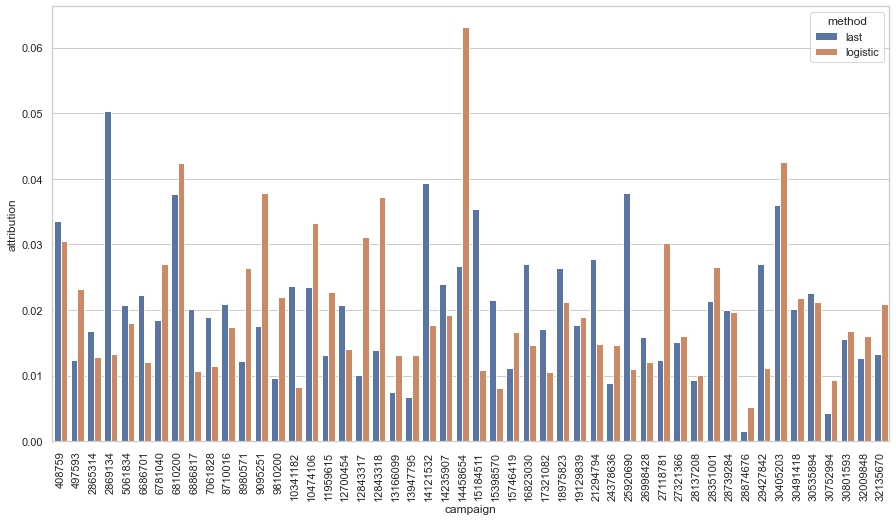

In [30]:
ax = sns.barplot(x=total_att.campaign, y=total_att.attribution, hue=total_att.method)
ax.figure.set_size_inches(15, 8)
ax.set_xticklabels(labels=campaign_names , rotation=90)

plt.show()

---

---

---

# 마케팅 예산 분배 시뮬레이션
1. 예산 및 샘플 수 지정 후 캠페인의 기여도에 맞게 예산 분배
2. 과거 데이터의 전환 내역을 통해 시뮬레이션 진행
    - 캠페인이 노출되었다면 각 캠페인에 배분된 예산을 -1 차감하고,
    - 전환이 되었다면 전환에 전이를 넣음
    - 캠페인이 노출되었는데 해당 캠페인의 예산이 0인 상태라면 전이를 blacklist에 넣어줌
3. 시뮬레이션 계산은 conversion - blacklist 로 진행

### 시뮬레이션을 위한 함수 정의

In [36]:
def get_campaign_id(x_journey_step):
    """한 여정 데이터에서 노출된 캠페인ID를 리턴해주는 함수"""
    return np.argmax(x_journey_step[:50])

def simulate_budget_roi(df, budget_total, attribution):
    # Input Weight만큼 예산을 각 캠페인에 할당
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    # 예산을 다 써서 시뮬레이션을 더 이상 진행할 수 없는 Journey : blacklist 생성
    blacklist = set()

    # Conversion 이 일어난 Journey  
    conversions = set()

    # 데이터셋을 돌면서 시뮬레이션 시작
    for i in range(df.shape[0]):   
        # 해당 이벤트에서 노출된 캠페인 ID 를 가져오고                               
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        # 해당 jid를 가져온다.
        jid = df.loc[i]['jid']

        # jid가 blacklist에 없고,
        if jid not in blacklist:
            
            # 해당 캠페인에 대한 예산이 있다면
            if budgets[campaign_id] >= 1:

                # 예산에서 1을 차감하고,
                budgets[campaign_id] = budgets[campaign_id] - 1

                # 전환했다면
                if(df.loc[i]['conversion'] == 1):
                    # 해당 jid를 conversion에 추가
                    conversions.add(jid)
            
            # 해당 캠페인에 대한 예산이 없다면,
            else:
                # 해당 jid에 대한 시뮬레이션을 못하게끔 blacklist에 추가
                blacklist.add(jid)
    
    print(f"Conversions : {len(conversions)}, Blacklist : {len(blacklist)}", end="\t")
    # 설정한 예산 및 샘플 수 안에 전환된 전이와 캠페인 광고를 진행하지 못했다고 가정한 blacklist의 차이를 반환
    return len(conversions.difference(blacklist))

---

### 샘플 수 및 기여도에 대한 하이퍼 파라미터 설정

In [37]:
# 10000개의 이벤트에 대해 시뮬레이션 진행
sample_data = df.sample(n=10000, random_state=6666)
sample_data = sample_data.sort_values('mm_timestamp')

In [38]:
# 하이퍼 파라미터 정의
hyper_params = np.arange(0.0, 3.0, 0.5)
hyper_params

array([0. , 0.5, 1. , 1.5, 2. , 2.5])

---

### Last Attribution 시뮬레이션 진행
- 예산 5000 설정

In [39]:
budget_total = 5000
attribution = last_att_weights

budget_last_att = []
for param in hyper_params:
    conversion = simulate_budget_roi(sample_data.reset_index(), budget_total, attribution**param)
    print(param, conversion)
    budget_last_att.append(conversion)

Conversions : 1799, Blacklist : 5155	0.0 1763
Conversions : 1933, Blacklist : 5101	0.5 1904
Conversions : 1938, Blacklist : 5276	1.0 1906
Conversions : 1853, Blacklist : 5545	1.5 1818
Conversions : 1745, Blacklist : 5830	2.0 1711
Conversions : 1611, Blacklist : 6131	2.5 1581


---

### Logistic Regression Attribution 시뮬레이션 진행

In [40]:
budget_total = 5000
attribution = logistic_reg_weights

budget_logreg = []
for param in hyper_params:
    conversion = simulate_budget_roi(sample_data.reset_index(), budget_total, attribution**param)
    print(param, conversion)
    budget_logreg.append(conversion)

Conversions : 1799, Blacklist : 5155	0.0 1763
Conversions : 1819, Blacklist : 5221	0.5 1789
Conversions : 1706, Blacklist : 5500	1.0 1680
Conversions : 1537, Blacklist : 5880	1.5 1515
Conversions : 1347, Blacklist : 6290	2.0 1329
Conversions : 1178, Blacklist : 6702	2.5 1160


---

### 두 모델의 기여도에 대한 시뮬레이션 결과 시각화 및 분석
- 전체적으로 Last Attribution의 결과가 Logistic Regression 보다 전환이 많이 일어났다.
- Last Attribution 시뮬레이션 중 hyper parameter가 1.0일 때의 전환이 가장 높게 나타났다.

#### 따라서 캠페인을 통해 광고 집행 예산 최적화는 Last Attribution Model & Hyper Parameter : 1 일 때의 기여도를 통해 진행한다면, 효율적으로 예산을 사용할 수 있다고 할 수 있다.

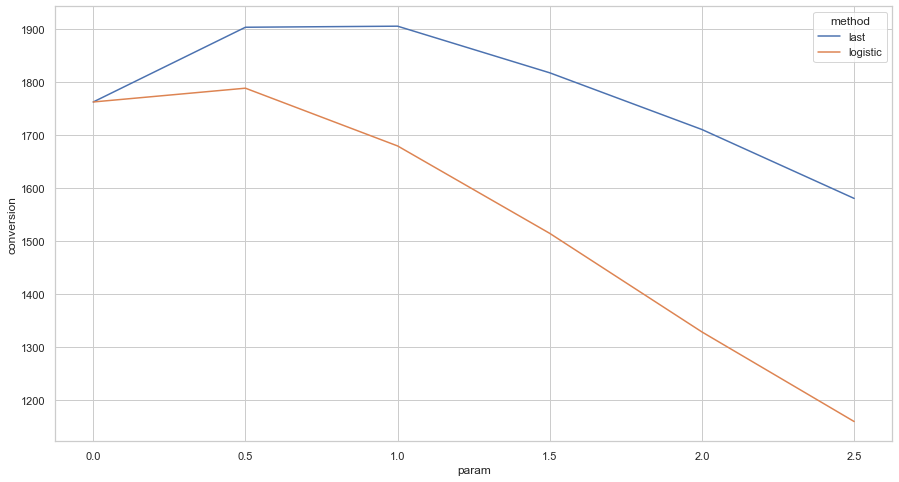

In [41]:
data1 = pd.DataFrame({"conversion":budget_last_att, "method": "last", "param": hyper_params})
data2 = pd.DataFrame({"conversion":budget_logreg, "method": "logistic", "param": hyper_params})
total = pd.concat([data1, data2]).reset_index()

ax = sns.lineplot(x=total.param ,y=total.conversion, hue=total.method)
ax.figure.set_size_inches(15, 8)